In [1]:
import yfinance as yf
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Set environment variable to avoid subprocess issues
os.environ["LOKY_MAX_CPU_COUNT"] = "1"

# List of top 100 most important stock tickers (example tickers, adjust as needed)
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "META", "BRK-B", "JPM", "V", "JNJ", "WMT", "PG", "UNH", "HD", "MA", "DIS", "PYPL", "NFLX", "KO", "PEP", "NKE", "XOM", "MRK", "PFE", "ABBV", "T", "CVX", "MCD", "INTC", "AMD", "IBM", "GE", "F", "GM", "CAT", "BA", "GS", "MS", "C", "LMT", "SPGI", "NOW", "ADBE", "CRM", "TXN", "QCOM", "AVGO", "DHR", "LIN", "TMO", "LOW", "DUK", "SO", "NEE", "EXC", "SBUX", "BKNG", "CHTR", "BLK", "MO", "DE", "ISRG", "MDT", "GILD", "ILMN", "SYK", "VRTX", "BMY", "ZTS", "CI", "CME", "ICE", "SCHW", "FDX", "UPS", "CSX", "NSC", "UNP", "MAR", "HLT", "APD", "SHW", "ECL", "PPG", "CL", "EL", "DG", "ROST", "TJX", "TGT", "COST", "CVS", "WBA", "MET", "PRU", "AIG", "ALL", "TRV", "AFL", "MMC", "SPG", "PLD"]

# Download data (only 'Close' prices)
data = yf.download(tickers, period="1y", interval="1d", progress=False)["Close"]

# Rename index to 'date'
data.index.name = "date"

In [3]:
# Print available columns
print("Available columns:", data.columns)

# Print data head
print(data.head())

Available columns: Index(['AAPL', 'ABBV', 'ADBE', 'AFL', 'AIG', 'ALL', 'AMD', 'AMZN', 'APD',
       'AVGO',
       ...
       'TXN', 'UNH', 'UNP', 'UPS', 'V', 'VRTX', 'WBA', 'WMT', 'XOM', 'ZTS'],
      dtype='object', name='Ticker', length=103)
Ticker            AAPL        ABBV        ADBE        AFL        AIG  \
date                                                                   
2024-02-15  182.995926  170.383347  590.440002  78.478180  68.828255   
2024-02-16  181.453201  171.251724  546.659973  77.704857  68.573700   
2024-02-20  180.706711  169.572876  541.909973  77.606339  66.703667   
2024-02-21  181.463181  168.984299  538.520020  78.079185  67.242157   
2024-02-22  183.503525  170.537720  537.570007  78.463371  69.396103   

Ticker             ALL         AMD        AMZN         APD        AVGO  ...  \
date                                                                    ...   
2024-02-15  158.573120  176.759995  169.800003  221.064728  124.825699  ...   
2024-02-16  1

In [4]:
# Compute daily returns
daily_returns = data.pct_change().dropna()

# Compute volatility (standard deviation of returns)
volatility = daily_returns.std()

# Prepare data for clustering
features = pd.DataFrame({"Mean_Return": daily_returns.mean(), "Volatility": volatility})

# Ensure all 100 stocks are included
print(f"Stocks included in clustering: {features.shape[0]}")
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


Stocks included in clustering: 103


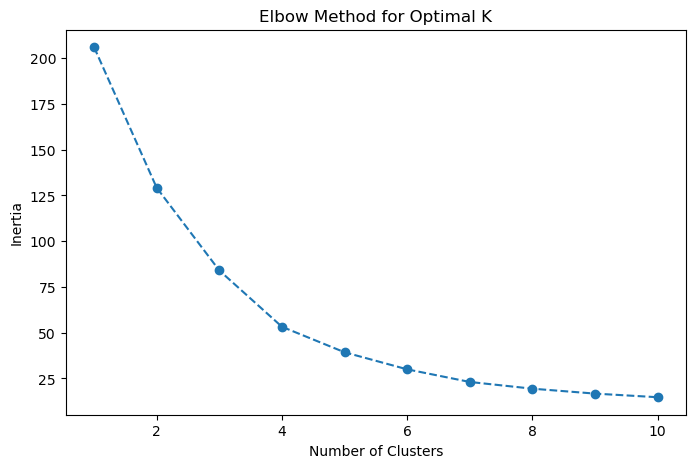

In [5]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

In [6]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
features["Cluster"] = kmeans.fit_predict(scaled_features)

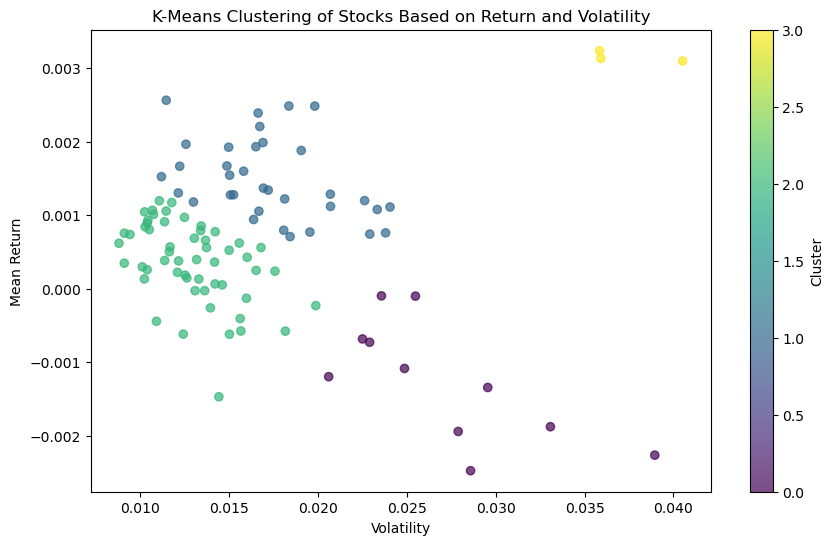

In [7]:
# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(features["Volatility"], features["Mean_Return"], c=features["Cluster"], cmap="viridis", alpha=0.7)
plt.xlabel("Volatility")
plt.ylabel("Mean Return")
plt.title("K-Means Clustering of Stocks Based on Return and Volatility")
plt.colorbar(label="Cluster")
plt.show()

In [8]:
# Print verification
print("Clustered Stocks:")
print(features.head())

print("K-Means clustering completed and saved successfully.")

Clustered Stocks:
        Mean_Return  Volatility  Cluster
Ticker                                  
AAPL       0.001274    0.015071        1
ABBV       0.000619    0.015570        2
ADBE      -0.000730    0.022902        0
AFL        0.001170    0.011767        2
AIG        0.000395    0.013166        2
K-Means clustering completed and saved successfully.


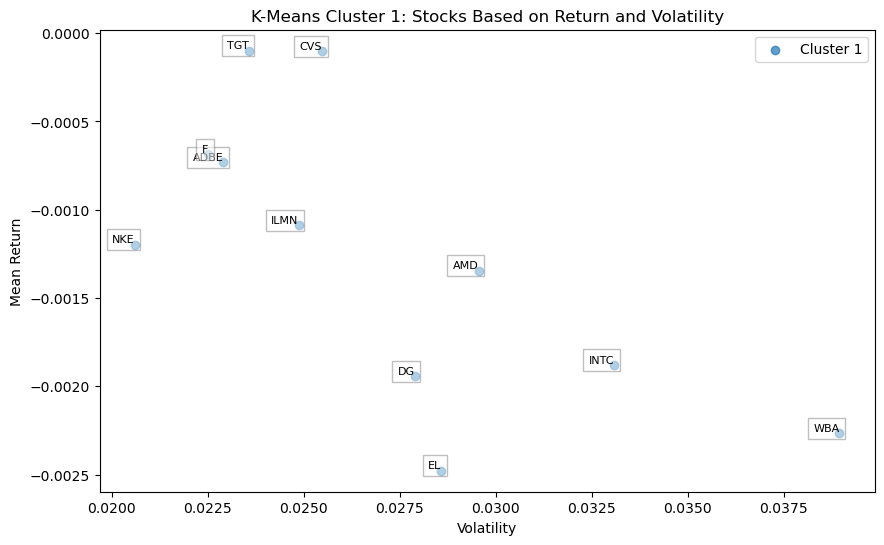

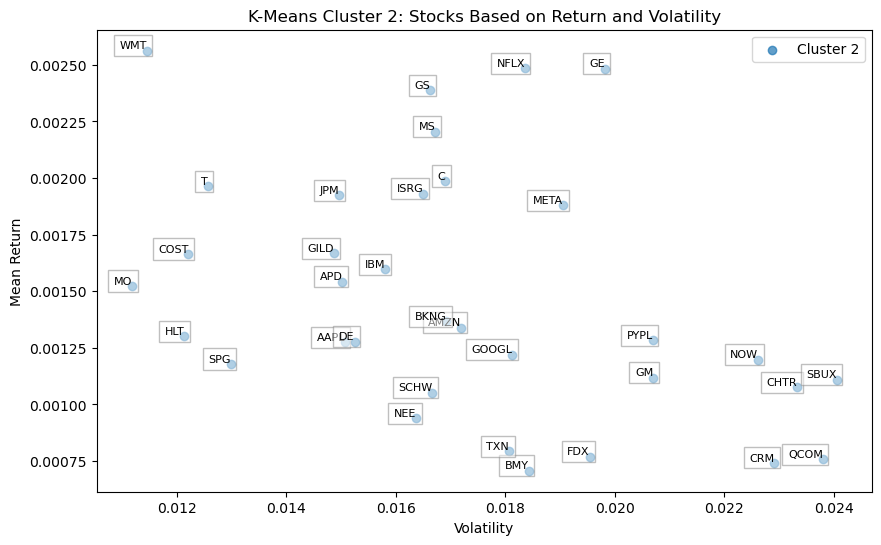

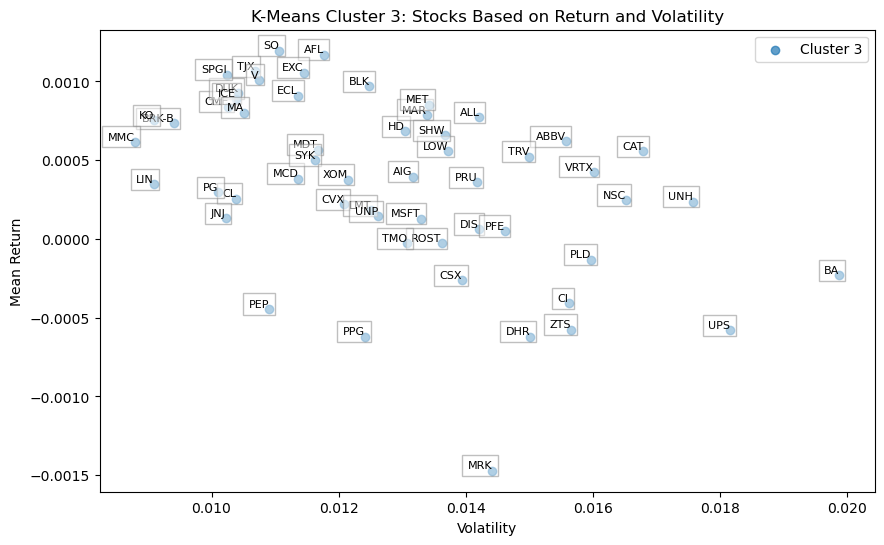

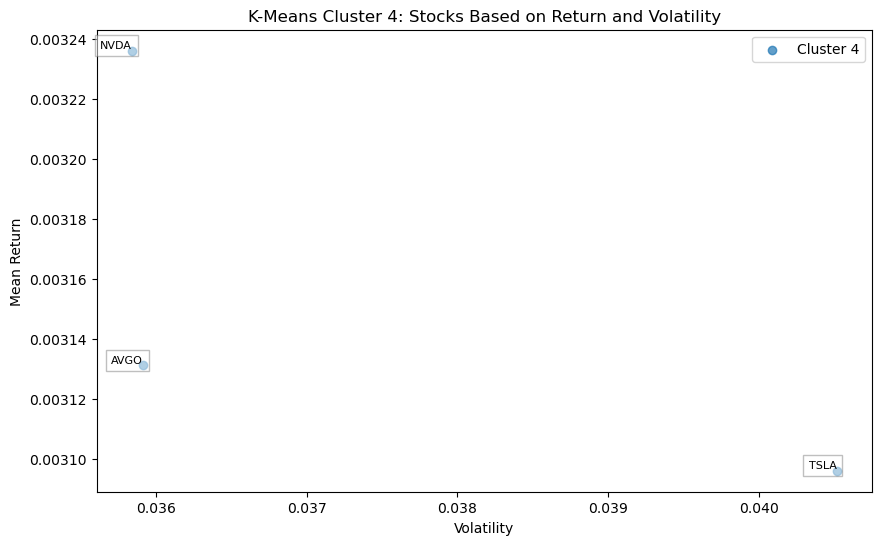

In [9]:
# Plot clusters separately with better label separation
for cluster in range(4):
    cluster_data = features[features["Cluster"] == cluster]
    plt.figure(figsize=(10, 6))
    plt.scatter(cluster_data["Volatility"], cluster_data["Mean_Return"], label=f"Cluster {cluster + 1}", alpha=0.7)
    
    # Improve label placement to prevent overlap
    for i, ticker in enumerate(cluster_data.index):
        plt.annotate(ticker, 
                     (cluster_data["Volatility"].iloc[i], cluster_data["Mean_Return"].iloc[i]),
                     fontsize=8, ha='right', va='bottom', 
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))
    
    plt.xlabel("Volatility")
    plt.ylabel("Mean Return")
    plt.title(f"K-Means Cluster {cluster + 1}: Stocks Based on Return and Volatility")
    plt.legend()
    plt.show()

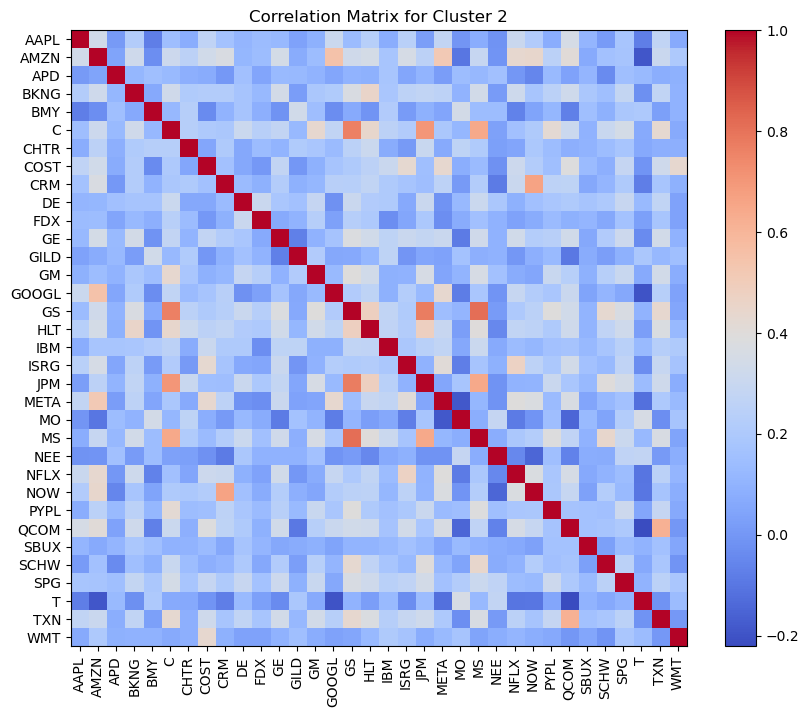

In [10]:
# Compute correlation matrix for Cluster 2
cluster_2_tickers = features[features["Cluster"] == 1].index
cluster_2_returns = daily_returns[cluster_2_tickers]
corr_matrix_2 = cluster_2_returns.corr()

# Plot correlation matrix for Cluster 2
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap("coolwarm")
plt.imshow(corr_matrix_2, cmap=cmap, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(cluster_2_tickers)), cluster_2_tickers, rotation=90)
plt.yticks(range(len(cluster_2_tickers)), cluster_2_tickers)
plt.title("Correlation Matrix for Cluster 2")
plt.show()